# Description

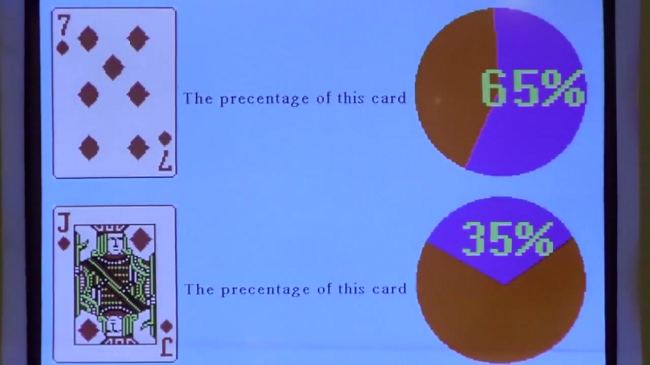

This Project was Inspired by God of Gamblers II (賭俠)

CNN Object Detection
Two Approaches: Transfer Learning Using YoloV3, Training My Own Network

The Dataset Has Already Been Split, Augmentated and Labelled

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pac
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# Loading the Dataset

Download the Labelized Playing Cards Dataset

https://www.kaggle.com/hugopaigneau/playing-cards-dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/Machine Learning Projects/(Kaggle) API Token"

In [4]:
%cd /content/drive/My Drive/Colab Notebooks/Machine Learning Projects/Playing Card Object Detection/Dataset

/content/drive/My Drive/Colab Notebooks/Machine Learning Projects/Playing Card Object Detection/Dataset


In [5]:
#!kaggle datasets download -d hugopaigneau/playing-cards-dataset

In [6]:
#!unzip 'playing-cards-dataset.zip'

In [7]:
train_cards_label = pd.read_csv('train_cards_label.csv')
test_cards_label = pd.read_csv('test_cards_label.csv')
cards_names = pd.read_csv('cards.names', header=None)

# Data Analysis and Visualization

The label document contains filename, dimension of the image, class (which card number) and the corresponding coordinates

In [8]:
train_cards_label.head()

filename  width  height class  xmin  ymin  xmax  ymax
0  627194074.jpg   1080    1080    9s    82   724   147   752
1  627194074.jpg   1080    1080    Qc    85   584   153   640
2  627194074.jpg   1080    1080    2h   164   470   213   524
3  627194074.jpg   1080    1080    6s   276   380   315   443
4  627194074.jpg   1080    1080    Qd   395   342   433   409

There are 5000 images in the train set and 1000 images in the test set with 52 unique cards (label)

In [9]:
print('Train,', 'Test,', 'Unique Cards')
len(train_cards_label['filename'].unique()), len(test_cards_label['filename'].unique()), len(cards_names)

Train, Test, Unique Cards


(5000, 1000, 52)

<BarContainer object of 52 artists>

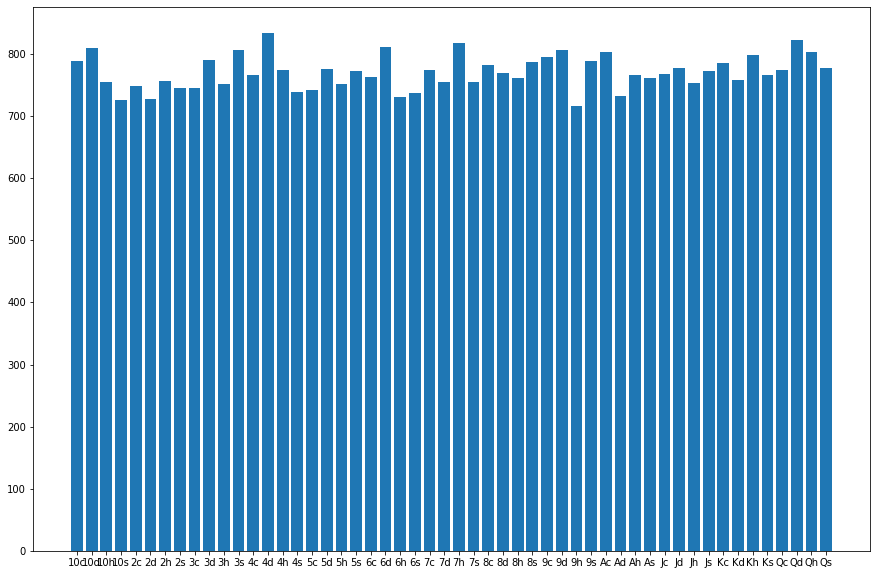

In [10]:
train_class_count = train_cards_label.groupby(by='class').count()
test_class_count = test_cards_label.groupby(by='class').count()
all_count = pd.DataFrame({'Train': train_class_count['filename'], 'Test': test_class_count['filename']})

fig, ax = plt.subplots(figsize=(15, 10))

ax.bar(all_count.index, all_count['Train'])


We can also visualize the bounding boxes with randomly selected image from the train set

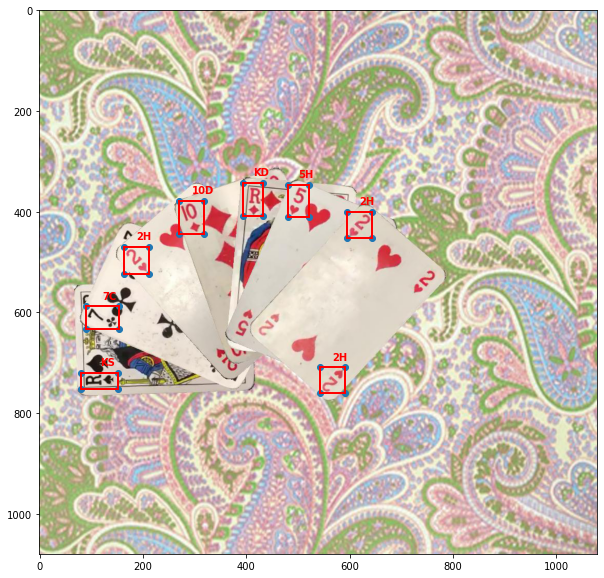

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))
rand_train_cards = np.random.randint(len(train_cards_label))
random_train_img = train_cards_label.iloc[rand_train_cards]
img = plt.imread('train_zipped/' + random_train_img[0])

cards = train_cards_label[train_cards_label['filename'] == random_train_img[0]]
xmin, ymin, xmax, ymax, class_ = cards['xmin'], cards['ymin'], cards['xmax'], cards['ymax'], cards['class']

for i in cards.index:
  rect = pac.Rectangle((xmin[i], ymin[i]), xmax[i] - xmin[i], ymax[i] - ymin[i], 
                       fill=False, color='r', linewidth=2)
  plt.gca().add_patch(rect)
  ax.annotate(cards['class'][i].upper(), (((xmax[i] - xmin[i]) / 2) + xmin[i], ymin[i] -15), color='r', weight='bold')

ax.scatter([xmin, xmax, xmin, xmax], [ymin, ymax, ymax, ymin])
ax.imshow(img, aspect='auto')


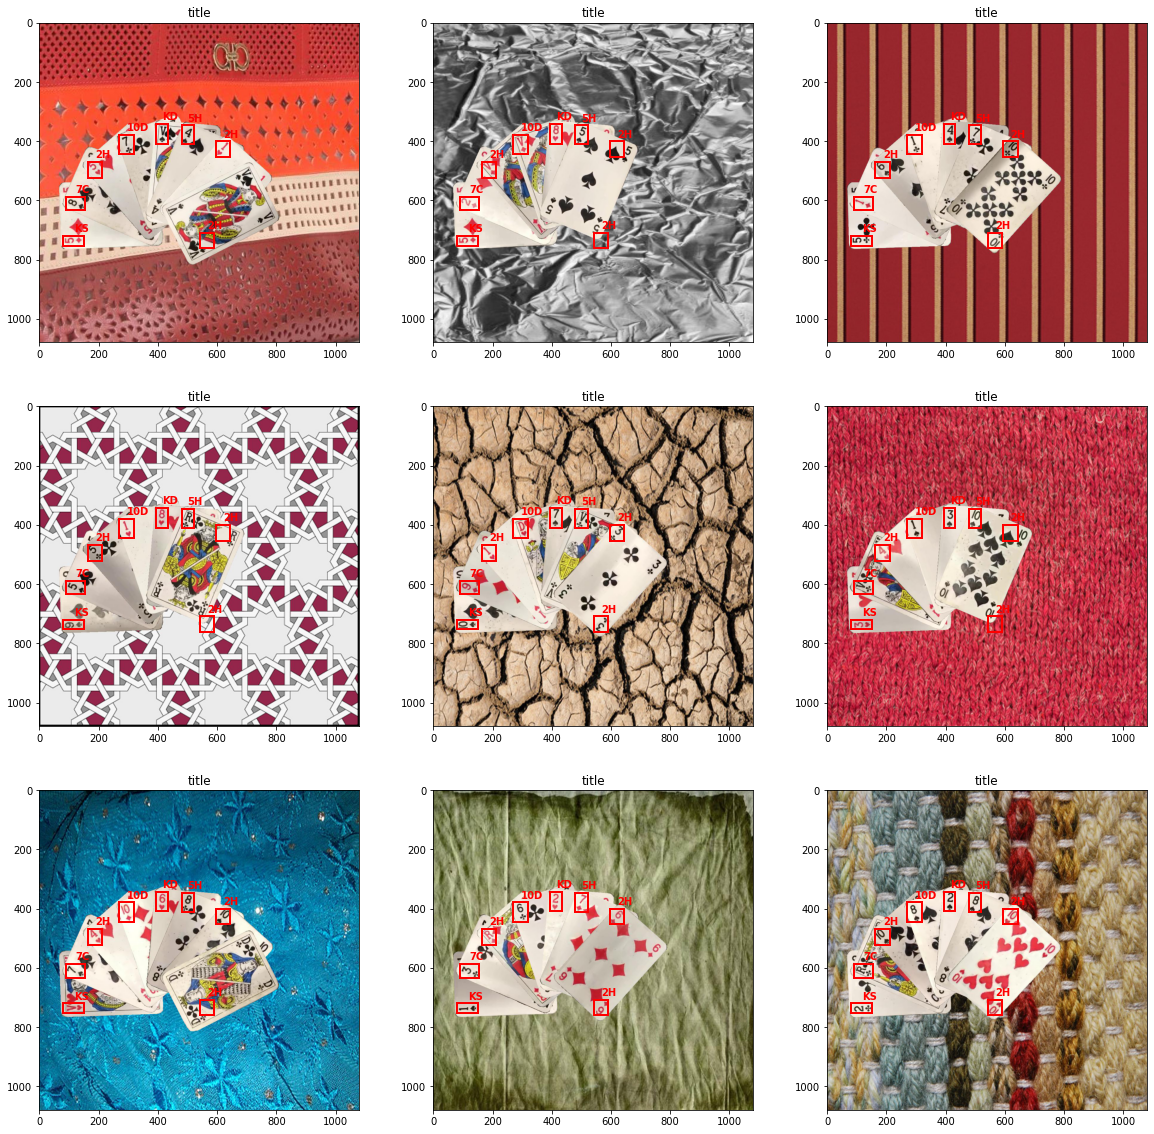

In [149]:
random_img_index = []
img_list = []
cards = train_cards_label[train_cards_label['filename'] == random_train_img[0]]
xmin, ymin, xmax, ymax, class_ = cards['xmin'], cards['ymin'], cards['xmax'], cards['ymax'], cards['class']

fig = plt.figure(figsize=(20, 20))

for i in range(9):
  n = np.random.randint(len(train_cards_label))
  random_img_index.append(n)

filename = train_cards_label.iloc[random_img_index]['filename']

for i in random_img_index:
  img = plt.imread('train_zipped/' + train_cards_label.iloc[i][0])
  img_list.append(img)

#for i in filename.index:
#  image = train_cards_label[train_cards_label['filename'] == filename[i]]
#  xmin, ymin, xmax, ymax, class_ = cards['xmin'], cards['ymin'], cards['xmax'], cards['ymax'], cards['class']

for i in range(len(img_list)):
  fig.add_subplot(3, 3, i + 1)
  plt.gca().set_title('title')
  plt.imshow(img_list[i])
  #plt.scatter([xmin, xmax, xmin, xmax], [ymin, ymax, ymax, ymin])
  for i in cards.index:
    rect = pac.Rectangle((xmin[i], ymin[i]), xmax[i] - xmin[i], ymax[i] - ymin[i], 
                         fill=False, color='r', linewidth=2)
    plt.gca().add_patch(rect)
    plt.annotate(cards['class'][i].upper(), (((xmax[i] - xmin[i]) / 2) + xmin[i], ymin[i] -15), color='r', weight='bold')

In [167]:
random_img_index

[38796, 62, 24906, 34926, 6331, 5164, 24491, 18843, 32809]

KeyError: ignored

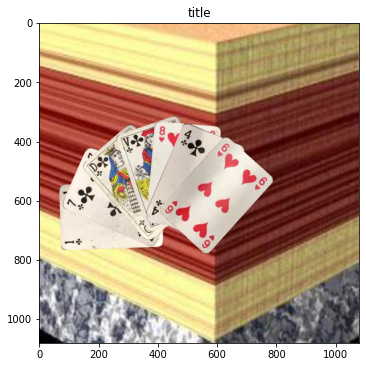

In [172]:
random_img_index = []
img_list = []
cards = train_cards_label[train_cards_label['filename'] == random_train_img[0]]
#xmin, ymin, xmax, ymax, class_ = cards['xmin'], cards['ymin'], cards['xmax'], cards['ymax'], cards['class']

fig = plt.figure(figsize=(20, 20))

for i in range(9):
  n = np.random.randint(len(train_cards_label))
  random_img_index.append(n)

filename = train_cards_label.iloc[random_img_index]['filename']

for i in random_img_index:
  img = plt.imread('train_zipped/' + train_cards_label.iloc[i][0])
  img_list.append(img)

for i in range(len(img_list)):
  fig.add_subplot(3, 3, i + 1)
  plt.gca().set_title('title')
  plt.imshow(img_list[i])
  #plt.scatter([xmin, xmax, xmin, xmax], [ymin, ymax, ymax, ymin])
  for j in filename.index:
    image = train_cards_label[train_cards_label['filename'] == filename[j]]
    xmin, ymin, xmax, ymax, class_ = image['xmin'], image['ymin'], image['xmax'], image['ymax'], ['class']
    rect = pac.Rectangle((xmin[i], ymin[i]), xmax[i] - xmin[i], ymax[i] - ymin[i], 
                         fill=False, color='r', linewidth=2)
    plt.gca().add_patch(rect)
    plt.annotate(cards['class'][i].upper(), (((xmax[i] - xmin[i]) / 2) + xmin[i], ymin[i] -15), color='r', weight='bold')

In [168]:
train_cards_label.iloc[random_img_index]['filename']

38796    471691037.jpg
62       714671603.jpg
24906    759314237.jpg
34926    130647102.jpg
6331     623491653.jpg
5164     449394941.jpg
24491    027928866.jpg
18843    885801026.jpg
32809    902511124.jpg
Name: filename, dtype: object

In [166]:
filename = train_cards_label.iloc[random_img_index]['filename']
selected_list = []
image_ = pd.Series()
for i in filename.index:
  image = train_cards_label[train_cards_label['filename'] == filename[i]]
  selected_list.append(image)

pd.concat(selected_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


filename  width  height class  xmin  ymin  xmax  ymax
38789  471691037.jpg   1080    1080    8s    86   725   151   751
38790  471691037.jpg   1080    1080    Ad    89   593   151   631
38791  471691037.jpg   1080    1080    Jc   155   459   216   532
38792  471691037.jpg   1080    1080    Qh   273   379   319   450
38793  471691037.jpg   1080    1080   10s   397   340   431   407
...              ...    ...     ...   ...   ...   ...   ...   ...
32812  902511124.jpg   1080    1080    6c   398   342   429   406
32813  902511124.jpg   1080    1080    Ac   476   348   515   411
32814  902511124.jpg   1080    1080    4d   594   404   647   454
32815  902511124.jpg   1080    1080    3d   658   487   720   533
32816  902511124.jpg   1080    1080    3d   500   759   562   805

[75 rows x 8 columns]

In [13]:
train_cards_label[train_cards_label['filename'] == random_train_img[0]]

filename  width  height class  xmin  ymin  xmax  ymax
25688  768447216.jpg   1080    1080    Js    83   720   152   754
25689  768447216.jpg   1080    1080    8c    90   591   153   634
25690  768447216.jpg   1080    1080    5h   159   463   211   519
25691  768447216.jpg   1080    1080    Qh   271   379   319   450
25692  768447216.jpg   1080    1080    5s   400   341   429   405
25693  768447216.jpg   1080    1080    7c   474   350   520   416
25694  768447216.jpg   1080    1080    7c   529   657   575   723

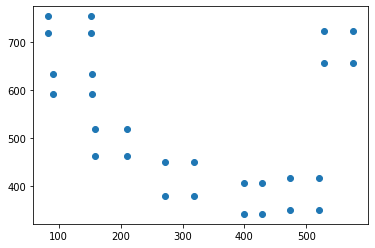

In [14]:
plt.scatter([xmin, xmax, xmin, xmax], [ymin, ymax, ymax, ymin])

Plotting Bounding Box

# Creating, Training CNN Model

## 1 Transfer Learning - YOLOv3

## 2 Building CNN

In [169]:
model = keras.models.Sequential([
  keras.layers.Conv2D(filters=20, kernel_size=8, strides=1, 
                      padding='Same', activation='relu', 
                      input_shape=(1080,1080,3)),
  keras.layers.MaxPooling2D((2, 2), strides=2),
  keras.layers.Conv2D(filters=20, kernel_size=8, strides=1,
                      padding='Same', activation='relu'),
  keras.layers.MaxPooling2D((2, 2), strides=4),
  keras.layers.Dropout(0.8),
  keras.layers.Dense(52) # 52 Different Cards
  # Output 52 Classes
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1080, 1080, 20)    3860      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 540, 540, 20)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 540, 540, 20)      25620     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 135, 135, 20)     0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 135, 135, 20)      0         
                                                                 
 dense_1 (Dense)             (None, 135, 135, 52)     

In [16]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')